In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Konfigurasi Plot
sns.set(style='whitegrid', palette='muted')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. IDENTIFIKASI MASALAH & DATASET (LOAD DATA)**

Dataset yang digunakan berupa data getaran bearing yang diperoleh dari sensor accelerometer, yang termasuk salah satu jenis sensor IoT dalam konteks Industrial Internet of Things (IIoT). Dataset ini diambil dari Kaggle, yaitu NASA Bearing Dataset, khususnya 2nd test dataset.

Pada 2nd test dataset, data terdiri dari 984 file sinyal getaran. Setiap file merepresentasikan snapshot sinyal getaran selama 1 detik yang direkam setiap 10 menit, dengan 4 channel yang masing-masing mewakili Bearing 1 hingga Bearing 4.

Setelah seluruh file digabungkan (merge) dan dilakukan ekstraksi fitur dengan menghitung mean absolute value pada setiap channel, diperoleh dataset deret waktu dengan ukuran 984 baris dan 4 kolom (984 × 4). Setiap baris merepresentasikan satu waktu pengambilan data, sedangkan setiap kolom merepresentasikan nilai getaran dari masing-masing bearing.


In [4]:

DATA_DIR = '/content/drive/MyDrive/Dataset/bearing-dataset/2nd_test'

def load_data(data_dir):
    print(f"Loading data from {data_dir}...")
    data_frames = []
    # Loop semua file dalam folder
    if not os.path.exists(data_dir):
        print(f"Error: Directory {data_dir} not found.")
        return None

    sorted_files = sorted(os.listdir(data_dir))
    for filename in sorted_files:
        filepath = os.path.join(data_dir, filename)
        if os.path.isfile(filepath): # Check if the path points to a file
            # Membaca file (setiap file adalah snapshot 1 detik getaran)
            dataset = pd.read_csv(filepath, sep='\t')

            # Mengambil rata-rata absolut (Mean Absolute) untuk meringkas snapshot
            dataset_mean_abs = np.array(dataset.abs().mean())
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
            dataset_mean_abs.index = [filename]
            data_frames.append(dataset_mean_abs)
        else:
            print(f"Skipping directory: {filepath}")

    if not data_frames: # Handle case where no files were processed
        print("No data files found to process.")
        return None

    # Gabungkan jadi satu dataframe Time-Series
    merged_data = pd.concat(data_frames)
    merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

    # Parsing index ke datetime
    merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
    merged_data = merged_data.sort_index()
    print(f"Data Loaded. Shape: {merged_data.shape}")
    return merged_data

# Eksekusi Load Data
df = load_data(DATA_DIR)


Loading data from /content/drive/MyDrive/Dataset/bearing-dataset/2nd_test...
Data Loaded. Shape: (984, 4)


# **2. PRA-PEMROSESAN & EKSPLORASI**

Pada tahap ini dilakukan pra-pemrosesan data untuk memastikan kualitas data sebelum digunakan dalam proses pemodelan. Langkah-langkah yang dilakukan meliputi pembersihan data dengan menghilangkan data yang tidak valid atau bernilai kosong, serta normalisasi data untuk menyamakan skala antar fitur sehingga proses pelatihan model menjadi lebih stabil dan optimal.

Selanjutnya, data deret waktu disegmentasi ke dalam beberapa window temporal dengan panjang tertentu. Proses segmentasi ini bertujuan untuk membentuk urutan data yang merepresentasikan kondisi getaran bearing dalam interval waktu tertentu, sehingga dapat dimanfaatkan oleh arsitektur CNN-LSTM dalam mengekstraksi fitur spasial dan memodelkan ketergantungan temporal.

Pada tahap eksplorasi data, dilakukan visualisasi distribusi kelas untuk memahami proporsi data normal dan anomali yang terdapat dalam dataset. Selain itu, pola getaran juga divisualisasikan guna mengamati perbedaan karakteristik sinyal antara kondisi normal dan kondisi anomali, sehingga memberikan pemahaman awal terhadap pola data yang akan dipelajari oleh model.


Distribusi Kelas:
label
0    513
1    471
Name: count, dtype: int64

Shape Input (X): (934, 50, 4)
Shape Label (y): (934,)

Shape Input (X): (934, 50, 4)
Shape Label (y): (934,)


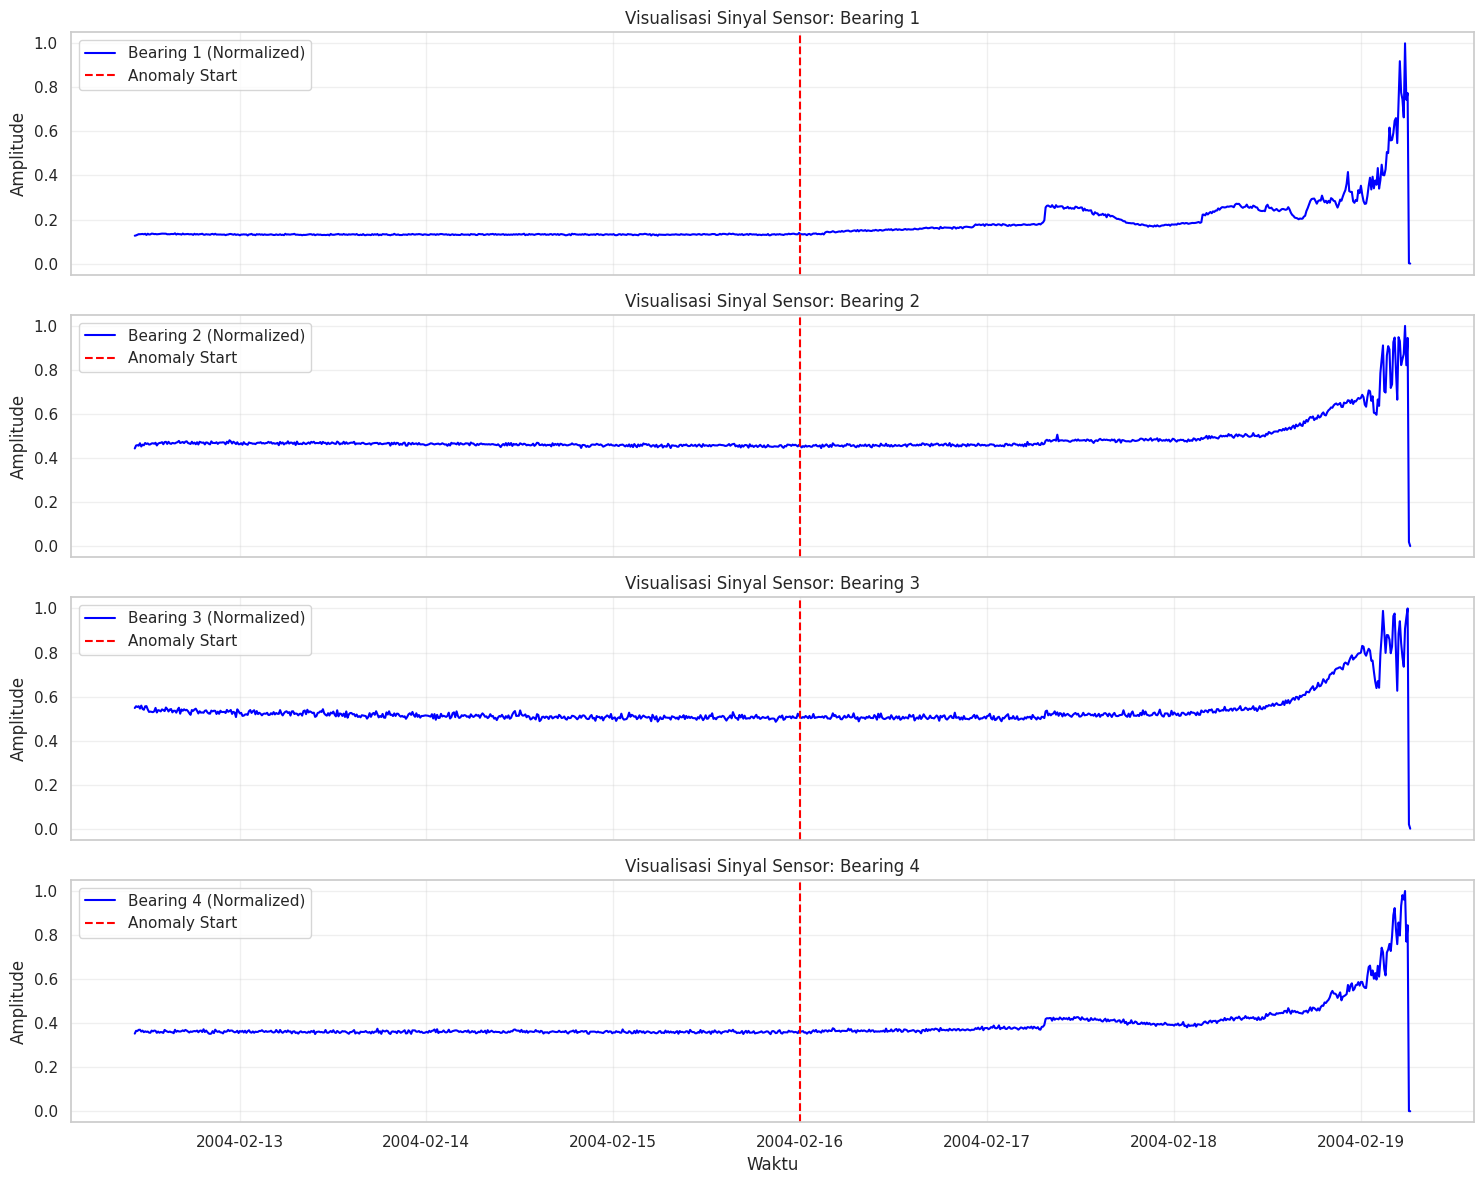

In [5]:


if df is not None:
    # --- A. Labeling (Membuat Ground Truth) ---
    # Asumsi: Data awal sehat (0), data akhir rusak (1)
    df['label'] = 0
    anomaly_start = '2004-02-16 00:00:00' # Titik mulai dianggap anomali/kritis
    df.loc[df.index >= anomaly_start, 'label'] = 1

    print("\nDistribusi Kelas:")
    print(df['label'].value_counts())

    # --- B. Normalisasi ---
    feature_cols = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
    scaler = MinMaxScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

   # --- C. Segmentasi Window (REVISI: MAXIMIZE DATA) ---
    def create_sequences(data, labels, time_steps=50, step=1):
        """
        Mengubah data time-series 2D menjadi 3D [Samples, TimeSteps, Features]
        """
        Xs, ys = [], []
        # Loop dengan step kecil agar data overlap banyak (Data Augmentation)
        for i in range(0, len(data) - time_steps, step):
            Xs.append(data.iloc[i:(i + time_steps)][feature_cols].values)
            ys.append(labels.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

#Parameter
    TIME_STEPS = 50
    STEP = 1

    X, y = create_sequences(df, df['label'], TIME_STEPS, STEP)

    print(f"\nShape Input (X): {X.shape}")
    print(f"Shape Label (y): {y.shape}")

    X, y = create_sequences(df, df['label'], TIME_STEPS, STEP)
    print(f"\nShape Input (X): {X.shape}") # (Samples, 60, 4)
    print(f"Shape Label (y): {y.shape}")

    # --- D. Visualisasi Pola (Semua Sensor) ---
    bearings = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

    # Membuat 4 grafik vertikal (Subplots)
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), sharex=True)

    for i, ax in enumerate(axes):
        # Plot data sensor
        ax.plot(df.index, df[bearings[i]], label=f'{bearings[i]} (Normalized)', color='blue')

        # Garis merah penanda mulainya Anomali
        ax.axvline(pd.to_datetime(anomaly_start), color='red', linestyle='--', label='Anomaly Start')

        # Kosmetik grafik
        ax.set_title(f"Visualisasi Sinyal Sensor: {bearings[i]}")
        ax.set_ylabel('Amplitude')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

    plt.xlabel('Waktu')
    plt.tight_layout()
    plt.show()

**3. SPLIT DATA**

Pada tahap ini, dataset dibagi menjadi tiga bagian, yaitu data latih (training), data validasi (validation), dan data uji (testing). Pembagian dilakukan secara acak (shuffle) namun tetap menjaga proporsi kelas normal dan anomali menggunakan teknik stratified sampling.

Sebanyak 70% data digunakan sebagai data latih, sedangkan 30% sisanya dibagi kembali secara seimbang menjadi data validasi (15%) dan data uji (15%).

In [6]:


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=y_temp
)

print(f"Train set - Normal: {len(y_train[y_train==0])}, Anomaly: {len(y_train[y_train==1])}")
print(f"Test set  - Normal: {len(y_test[y_test==0])}, Anomaly: {len(y_test[y_test==1])}")

Train set - Normal: 324, Anomaly: 329
Test set  - Normal: 70, Anomaly: 71


# **4. PERANCANGAN ARSITEKTUR HYBRID CNN-LSTM**

Arsitektur Model Hybrid CNN–LSTM

Model yang digunakan merupakan arsitektur hybrid CNN–LSTM, di mana Convolutional Neural Network (CNN) berperan untuk mengekstraksi fitur spasial dari data getaran pada setiap window, sedangkan Long Short-Term Memory (LSTM) digunakan untuk memodelkan ketergantungan temporal pada deret waktu.

1. CNN Ekstraksi Fitur Spasial

Lapisan Conv1D digunakan untuk menangkap pola lokal pada sinyal getaran bearing.

Lapisan konvolusi pertama menggunakan 64 filter untuk mengekstraksi fitur awal dari sinyal.

Lapisan konvolusi kedua menggunakan 32 filter untuk memperdalam representasi fitur.
Setiap lapisan konvolusi diikuti oleh MaxPooling1D untuk mereduksi dimensi data dan Dropout untuk mengurangi risiko overfitting.

2. LSTM  Pemodelan Ketergantungan Waktu

Output dari CNN diteruskan ke lapisan LSTM dengan 60 unit, yang berfungsi untuk mempelajari hubungan temporal antar window data getaran. Lapisan ini memungkinkan model memahami perubahan pola getaran seiring waktu yang berkaitan dengan kondisi normal maupun anomali.

3. Dense  Klasifikasi

Hasil dari LSTM diproses oleh lapisan Dense dengan aktivasi ReLU sebagai pemetaan fitur tingkat tinggi, kemudian diakhiri dengan Dense beraktivasi sigmoid untuk menghasilkan probabilitas kelas normal (0) atau anomali (1).

Model dikompilasi menggunakan optimizer Adam, fungsi loss binary cross-entropy, dan metrik akurasi, yang sesuai untuk tugas klasifikasi biner.

In [7]:


def build_hybrid_model(input_shape):
    model = Sequential([
        # --- 1. CNN Layers (Ekstraksi Fitur Spasial) ---
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # --- 2. LSTM Layers  ---

        LSTM(60, return_sequences=False, unroll=True),
        Dropout(0.3),

        # --- 3. Dense Layers (Klasifikasi) ---
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid') # Output biner (0 - 1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
model = build_hybrid_model(input_shape)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60)             │        22,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,313 (122.32 KB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 0 (0.00 B)

# **5. PELATIHAN MODEL**

Model dilatih menggunakan data latih dengan menerapkan class weight untuk mengatasi ketidakseimbangan antara kelas normal dan anomali. Proses pelatihan menggunakan Early Stopping untuk menghentikan training ketika performa validasi tidak lagi meningkat, serta Model Checkpoint untuk menyimpan model terbaik berdasarkan nilai validation loss. Pelatihan dilakukan selama maksimal 50 epoch dengan ukuran batch 32.

In [8]:

from sklearn.utils.class_weight import compute_class_weight

# Hitung bobot kelas (untuk mengatasi ketidakseimbangan data jika ada)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),

    ModelCheckpoint('best_hybrid_model.keras', monitor='val_loss', save_best_only=True)
]

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Class Weights: {0: np.float64(1.007716049382716), 1: np.float64(0.9924012158054711)}
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - accuracy: 0.4963 - loss: 0.6917 - val_accuracy: 0.5071 - val_loss: 0.6773
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5393 - loss: 0.6667 - val_accuracy: 0.7857 - val_loss: 0.5842
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8335 - loss: 0.4684 - val_accuracy: 0.7643 - val_loss: 0.5123
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8533 - loss: 0.3529 - val_accuracy: 0.8286 - val_loss: 0.3540
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8909 - loss: 0.2925 - val_accuracy: 0.8214 - val_loss: 0.3984
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8635 - loss: 0.3066 - val_accuracy: 0.8286 - val_loss: 0.3650
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9048 - loss: 0.2563 - val_accuracy: 0.9214 - val_loss: 0.2205
Epoch 8/50
21/21 ━━━━━━━━━━━━━

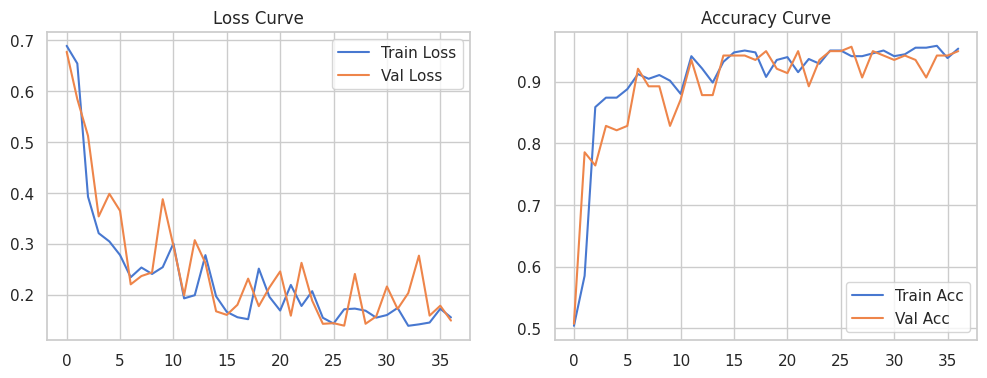

In [9]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# **6. EVALUASI MODEL**

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.92      1.00      0.96        70
     Anomaly       1.00      0.92      0.96        71

    accuracy                           0.96       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141



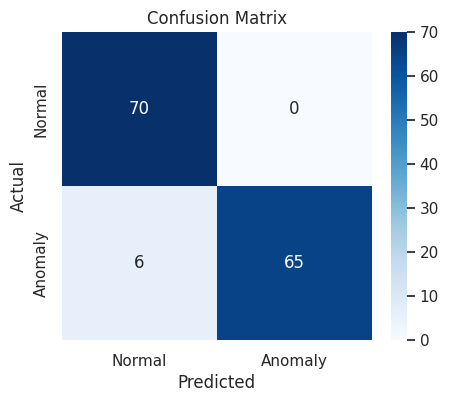

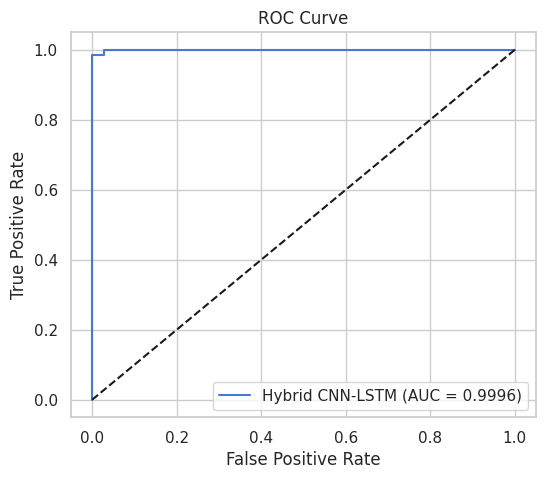

ROC-AUC Score: 0.9996


In [10]:


# Prediksi pada Data Test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# A. Metrics Dasar
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# C. ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Hybrid CNN-LSTM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Garis acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

# **7. BASELINE COMPARISON**

In [11]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- A. Baseline 1: SVM (Support Vector Machine) ---
print("\n--- Training Baseline: SVM ---")


n_samples_train, n_steps, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples_train, n_steps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], n_steps * n_features)

# Train SVM
svm_model = SVC(kernel='rbf', probability=True) # RBF kernel standar untuk non-linear
svm_model.fit(X_train_flat, y_train)

# Evaluasi SVM
y_pred_svm = svm_model.predict(X_test_flat)
acc_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm:.4f}")
print(f"SVM F1-Score: {f1_svm:.4f}")

# --- B. Baseline 2: Simple Autoencoder ---
print("\n--- Training Baseline: Autoencoder ---")


input_dim = X_train_flat.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer) # Bottleneck
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train (X sebagai input DAN target)
autoencoder.fit(X_train_flat, X_train_flat, epochs=20, batch_size=32, verbose=0)

# Prediksi (Rekonstruksi)
reconstructions = autoencoder.predict(X_test_flat)
mse = np.mean(np.power(X_test_flat - reconstructions, 2), axis=1)

# T threshold anomali (misal: rata-rata MSE + 2*std)
threshold_ae = np.mean(mse) + 2 * np.std(mse)
y_pred_ae = (mse > threshold_ae).astype(int)

acc_ae = accuracy_score(y_test, y_pred_ae)
f1_ae = f1_score(y_test, y_pred_ae)
print(f"Autoencoder Accuracy: {acc_ae:.4f}")
print(f"Autoencoder F1-Score: {f1_ae:.4f}")


--- Training Baseline: SVM ---
SVM Accuracy: 0.8936
SVM F1-Score: 0.8819

--- Training Baseline: Autoencoder ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Autoencoder Accuracy: 0.5390
Autoencoder F1-Score: 0.1558


# **8.HYPERPARAMETER TUNING**

In [12]:

!pip install keras-tuner --quiet
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Memulai Hyperparameter Tuning ---")

def build_tunable_model(hp):
    model = Sequential()

    # Tune jumlah filter di CNN layer 1
    hp_filters1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    model.add(Conv1D(filters=hp_filters1, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Tune jumlah unit di LSTM
    hp_lstm_units = hp.Int('lstm_units', min_value=30, max_value=100, step=10)


    model.add(LSTM(units=hp_lstm_units, return_sequences=False, unroll=True))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Setup Tuner
tuner = kt.RandomSearch(
    build_tunable_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='iot_anomaly_tuning_fixed'
)


tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 3 Complete [00h 00m 24s]
val_accuracy: 0.949999988079071

Best val_accuracy So Far: 0.949999988079071
Total elapsed time: 00h 01m 13s


# **9. EVALUASI AKHIR & RETRAINING**


--- Evaluasi Model Terbaik (Hasil Tuning) ---
Best LSTM Units: 100
Best Filters: 64
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 953ms/step - accuracy: 0.4700 - loss: 0.6934 - val_accuracy: 0.5071 - val_loss: 0.6890
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5239 - loss: 0.6867 - val_accuracy: 0.5071 - val_loss: 0.6829
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4992 - loss: 0.6833 - val_accuracy: 0.5071 - val_loss: 0.6760
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4883 - loss: 0.6760 - val_accuracy: 0.5071 - val_loss: 0.6632
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4876 - loss: 0.6625 - val_accuracy: 0.5071 - val_loss: 0.6328
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5410 - loss: 0.6145 - val_accuracy: 0.9571 - val_loss: 0.5250
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7981 - loss: 0.5057 - val_accuracy: 0.9429 - val_loss: 0.3993
Epoch 8/50
21/21 ━━━━━━━━━━━━━

1/5 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 550ms/step

=== CLASSIFICATION REPORT (BEST MODEL) ===
              precision    recall  f1-score   support

      Normal       0.91      1.00      0.95        70
     Anomaly       1.00      0.90      0.95        71

    accuracy                           0.95       141
   macro avg       0.95      0.95      0.95       141
weighted avg       0.95      0.95      0.95       141



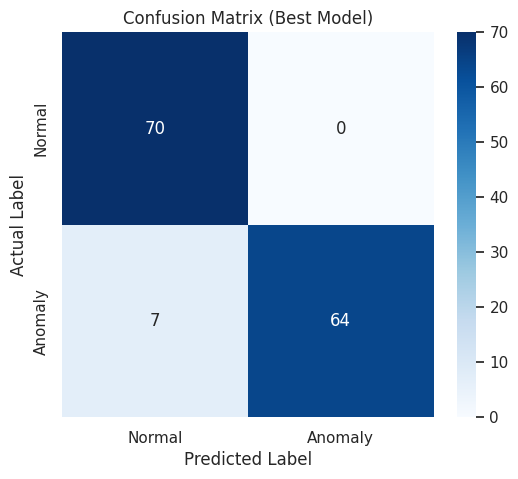

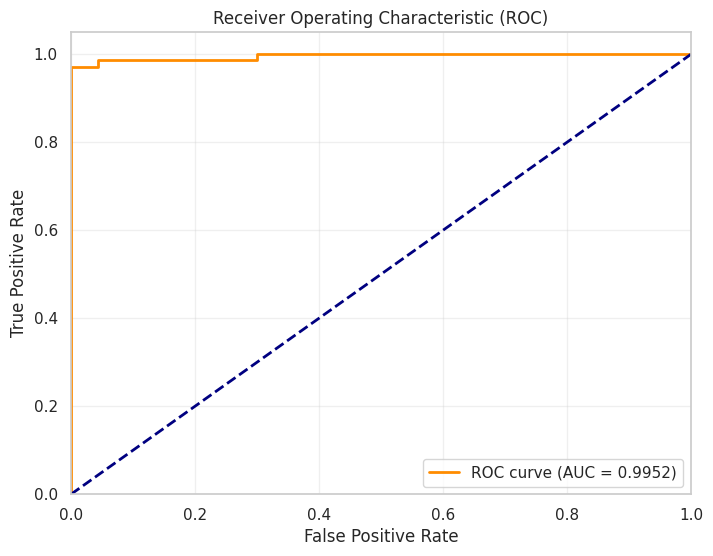

Final ROC-AUC Score: 0.9952


In [13]:

print("\n--- Evaluasi Model Terbaik (Hasil Tuning) ---")

# 1. Ambil Hyperparameter Terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Filters: {best_hps.get('filters_1')}")

# 2. Bangun Model
best_model = tuner.hypermodel.build(best_hps)

# 3. Latih Ulang (Retrain)
history_best = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# 4. Simpan Model
best_model.save('best_hybrid_model.keras')
print("✅ Model terbaik berhasil disimpan ke 'best_hybrid_model.keras'")

# 5. Prediksi pada Data Test
y_pred_prob_best = best_model.predict(X_test)
y_pred_best = (y_pred_prob_best > 0.5).astype(int)

# 6. Laporan Klasifikasi (Teks)
print("\n=== CLASSIFICATION REPORT (BEST MODEL) ===")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Anomaly']))


# 7. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix (Best Model)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 8. Plot ROC Curve
auc_score = roc_auc_score(y_test, y_pred_prob_best)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis diagonal (random guess)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final ROC-AUC Score: {auc_score:.4f}")

# **10.DEPLOYMENT: EXPORT KE WEB (TFJS) & TFLITE**

In [14]:


# 1. Install Library
!pip install tensorflowjs --no-deps --quiet

import tensorflow as tf
import tensorflowjs as tfjs
import os
import shutil

# Load ulang model yang baru saja disimpan untuk memastikan
best_model = tf.keras.models.load_model('best_hybrid_model.keras')

# --- A. Export ke TensorFlow.js (Untuk Web) ---
print("\n[1/2] Mengekspor ke format TensorFlow.js (Web)...")
tfjs_target_dir = "tfjs_model_output"

if os.path.exists(tfjs_target_dir):
    shutil.rmtree(tfjs_target_dir)

try:
    tfjs.converters.save_keras_model(best_model, tfjs_target_dir)
    print(f"✅ Sukses! Model Web tersimpan di folder: {tfjs_target_dir}/")
except Exception as e:
    print(f"⚠️ Warning TFJS: {e}")


# --- B. Export ke TensorFlow Lite (Untuk Android/IoT) ---
print("\n[2/2] Mengekspor ke format TensorFlow Lite (TFLite)...")

try:
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

    # Optimasi ukuran
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Konversi
    tflite_model = converter.convert()

    # Simpan ke file
    tflite_filename = "hybrid_cnn_lstm.tflite"
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

    print(f"✅ Sukses! Model TFLite tersimpan di file: {tflite_filename}")
    print(f"   Ukuran model: {len(tflite_model) / 1024:.2f} KB")

except Exception as e:
    print(f"❌ Gagal Export TFLite: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00



[1/2] Mengekspor ke format TensorFlow.js (Web)...
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Sukses! Model Web tersimpan di folder: tfjs_model_output/

[2/2] Mengekspor ke format TensorFlow Lite (TFLite)...
Saved artifact at '/tmp/tmp4_be6opf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 4), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135524089385552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089388240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089387280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089388432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089389200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089387856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135524089386512: TensorSpec(shape=(), dtype=tf.r

# **11. DOWNLOAD HASIL (ZIP & TFLITE)**

In [15]:

import shutil
import os

print("Sedang memproses file untuk diunduh...")

if os.path.exists('tfjs_model_output'):
    shutil.make_archive('model_tfjs', 'zip', 'tfjs_model_output')
    print("✅ Folder TFJS berhasil di-zip menjadi 'model_tfjs.zip'")
else:
    print("⚠️ Folder 'tfjs_model_output' tidak ditemukan.")

# 2. PROSES DOWNLOAD
try:
    from google.colab import files

    # Download TFJS Zip
    if os.path.exists('model_tfjs.zip'):
        files.download('model_tfjs.zip')

    # Download TFLite
    if os.path.exists('hybrid_cnn_lstm.tflite'):
        files.download('hybrid_cnn_lstm.tflite')

except ImportError:
    pass

Sedang memproses file untuk diunduh...
✅ Folder TFJS berhasil di-zip menjadi 'model_tfjs.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

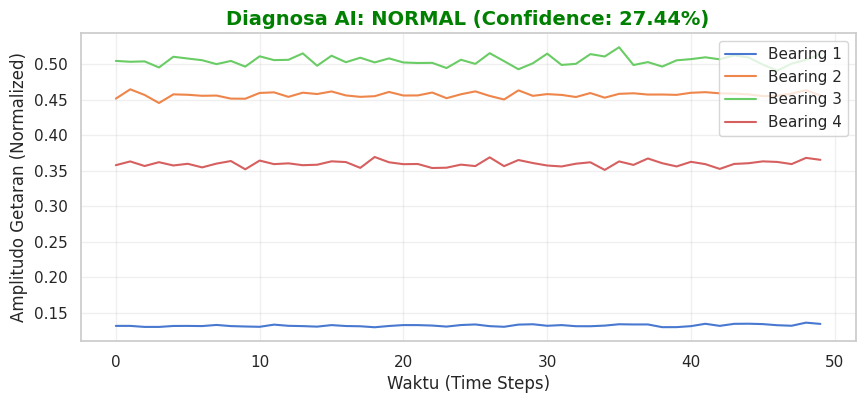

------------------------------
📡 STATUS MESIN: NORMAL
📊 Probability Kerusakan: 0.2744
✅ Label Asli (Kunci Jawaban): NORMAL
------------------------------


In [16]:
# ==========================================
# 11. INFERENCE / PREDIKSI DATA BARU (SIMULASI)
# ==========================================
import random
import numpy as np
import matplotlib.pyplot as plt

def predict_sensor_data(model, sample_data, true_label=None):
    """
    Fungsi untuk memprediksi satu sampel window (50 data points)
    """
    # 1. Reshape data agar sesuai input model (1, 50, 4)
    # Model butuh 3D array: [Batch_Size, Time_Steps, Features]
    input_data = np.expand_dims(sample_data, axis=0)

    # 2. Lakukan Prediksi
    prediction_prob = model.predict(input_data, verbose=0)[0][0]

    # 3. Tentukan Kelas (Threshold 0.5)
    prediction_class = "ANOMALI" if prediction_prob > 0.5 else "NORMAL"
    color = 'red' if prediction_prob > 0.5 else 'green'

    # --- VISUALISASI HASIL ---
    plt.figure(figsize=(10, 4))

    # Plot 4 Sensor
    plt.plot(sample_data, label=['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4'])
    plt.title(f"Diagnosa AI: {prediction_class} (Confidence: {prediction_prob:.2%})",
              fontsize=14, fontweight='bold', color=color)
    plt.ylabel('Amplitudo Getaran (Normalized)')
    plt.xlabel('Waktu (Time Steps)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print Text Output
    print("-" * 30)
    print(f"📡 STATUS MESIN: {prediction_class}")
    print(f"📊 Probability Kerusakan: {prediction_prob:.4f}")
    if true_label is not None:
        actual = "ANOMALI" if true_label == 1 else "NORMAL"
        print(f"✅ Label Asli (Kunci Jawaban): {actual}")
    print("-" * 30)

# --- JALANKAN SIMULASI ---
# ambil 1 sampel acak dari X_test untuk demo
random_idx = random.randint(0, len(X_test) - 1)
sample_window = X_test[random_idx]   # Data sensor (50 baris, 4 kolom)
label_actual = y_test[random_idx]    # Label asli (0 atau 1)

# Panggil fungsi inference
predict_sensor_data(best_model, sample_window, label_actual)

In [27]:
# ==========================================
# 12. INFERENCE DENGAN DATA MANUAL (RAW INPUT)
# ==========================================

def inference_raw_input(raw_data_array):
    """
    Simulasi jika data datang dalam bentuk list mentah/array numpy
    Data harus memiliki shape (50, 4) -> 50 titik waktu, 4 sensor
    """
    # 1. Pastikan input berbentuk numpy array
    data = np.array(raw_data_array)

    # 2. Cek Dimensi
    if data.shape != (50, 4):
        print(f"❌ Error: Data harus berukuran (50, 4). Data Anda: {data.shape}")
        return

    # 3. Prediksi (Asumsi data sudah ternormalisasi.
    # data = scaler.transform(data))

    input_tensor = np.expand_dims(data, axis=0) # Jadi (1, 50, 4)
    prob = best_model.predict(input_tensor, verbose=0)[0][0]

    status = "BAHAYA / ANOMALI" if prob > 0.5 else "AMAN / NORMAL"
    print(f"Hasil Analisis Manual: {status} (Prob: {prob:.4f})")

# --- CONTOH PEMAKAIAN ---

# Contoh 1: Data Getaran Rendah (Harusnya Normal)
fake_normal_data = np.random.normal(0.01, 0.01, size=(50, 4))

# Contoh 2: Data Getaran Sangat Tinggi (Harusnya Anomali)
fake_anomaly_data = np.random.normal(0.1, 0.1, size=(50, 4))

print("\n--- Tes 1: Input Getaran Rendah ---")
inference_raw_input(fake_normal_data)

print("\n--- Tes 2: Input Getaran Tinggi ---")
inference_raw_input(fake_anomaly_data)


--- Tes 1: Input Getaran Rendah ---
Hasil Analisis Manual: AMAN / NORMAL (Prob: 0.3947)

--- Tes 2: Input Getaran Tinggi ---
Hasil Analisis Manual: BAHAYA / ANOMALI (Prob: 0.9892)
